In [1]:
import pandas as pd

data = pd.read_excel('support_data.xlsx', index_col=0, sheet_name = 'data',
                     usecols = ['issuenum', 'description', 'region', 'year_created'],
                     converters = {'issuenum': int, 'description': str, 'region': str, 'year_created': int})

data.head()

description  \
issuenum                                                      
47076     добрый день! в комитет обращаются организации ...   
47075     день добрый! шаблон висит на сайте в статусе "...   
47074     рэк свердловской области просит сообщить дату ...   
47073     добрый день! не возможно сформировать листы в ...   
47072              в настройки отсутствует список регионов    

                         region  year_created  
issuenum                                       
47076     Ленинградская область          2019  
47075         Рязанская область          2019  
47074      Свердловская область          2019  
47073     Ленинградская область          2019  
47072      Республика Татарстан          2019

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24117 entries, 47076 to 11803
Data columns (total 3 columns):
description     24117 non-null object
region          24117 non-null object
year_created    24117 non-null int64
dtypes: int64(1), object(2)
memory usage: 753.7+ KB


In [3]:
%%time
# Предобработка

# Очистка от пунктуации
import re
def strip_punctuation(string):
    return re.sub(r'[^\w\s]', '', str(string))

data['text'] = data['description'].apply(strip_punctuation)

CPU times: user 241 ms, sys: 8.56 ms, total: 249 ms
Wall time: 249 ms


In [4]:
%%time
# Привести слова к начальной форме (лемматизация)
from pymystem3 import Mystem
m = Mystem()
data['text_lemma'] = data['text'].apply(lambda x: m.lemmatize(x))

CPU times: user 3.34 s, sys: 376 ms, total: 3.72 s
Wall time: 35.5 s


In [5]:
%%time
# Убрать слишком короткие комментарии, не несущие смысла
data['text_len'] = data['text'].apply(len)
data['text_word_num'] = data.apply(lambda row: row.text.count(' '), axis=1)

data = data[(data.text_len > 10)&(data.text_word_num > 3)]

CPU times: user 415 ms, sys: 7.44 ms, total: 423 ms
Wall time: 423 ms


In [6]:
data.to_excel('support_data_2.xlsx')

//anaconda3/lib/python3.7/site-packages/xlsxwriter/worksheet.py:915: UserWarning: Ignoring URL 'https://tariff.eias.ru/disclo/get_file?p_guid=38bda94b-8d27-4977-a187-74c7a586937c%20-%20ссылку%20такого%20вида%20заменила%20на%20%20https://regportal-tarif.ru/disclo/get_file?p_guid=a19cb469-6b41-4053-ab5a-8f533ba48293%20%20все%20равно%20документ%20не%20открывается.%20%20в%20приложенном%20шаблоне%20это%20лист%20!фидеры!%201%20и%202%20строки%20в%20столбце%20нормальная%20схема' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
//anaconda3/lib/python3.7/site-packages/xlsxwriter/worksheet.py:915: UserWarning: Ignoring URL 'https://regportal-tariff.ru/portal/modules/utk/present.aspx?id=5542%20-%20при%20попытке%20открыть%20вкладку%20%22организации%22%20портал%20долго%20грузится%20и%20выводит%20ошибку%20%22ошибка%20загрузки%20представления%22.%20такое%20происходит%20не%20каждый%20раз%20но%20часто.' with link or location/anchor > 255 charact

In [7]:
%%time
# Добавить биграммы

from gensim import corpora, models

# создаём объект для генерации биграм
# min_count и threshold нужны для обрезки слишком редких
bigram = models.Phrases(data.text_lemma, min_count=3, threshold=5)

# оборачиваем объект для быстрой обработки текста
bigram_mod = models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
# и генерируем текст с биграммами
texts = make_bigrams(data.text_lemma)

CPU times: user 6.86 s, sys: 102 ms, total: 6.96 s
Wall time: 6.96 s


In [8]:
%%time
# Токенизировать предложения (мешок слов/bag-of-words)
# Выкинуть слишком частые/редкие слова и словосочетания

from gensim import corpora, models

# составляем словарь из терминов
dictionary = corpora.Dictionary(texts)

# и убираем слишком редкие (no_below) и слишком частые (no_above)
dictionary.filter_extremes(no_below=3, no_above=0.4)

# наконец, составляем финальный готовый корпус
corpus = [dictionary.doc2bow(text) for text in texts]

print(dictionary)

Dictionary(9363 unique tokens: ['быть', 'возможный', 'вопрос', 'день', 'для']...)
CPU times: user 1.9 s, sys: 24.6 ms, total: 1.92 s
Wall time: 1.92 s


In [9]:
import pickle
with open('corpus', 'wb') as f:
    pickle.dump(corpus, f)

In [11]:
%%time
# Построение модели

from gensim import corpora, models

ldamodel = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=5)

# сохраняем
ldamodel.save("ldamodel_30_bigrams_long_comments")

# для каждого топика берём наиболее вероятный топ слов
topics = ldamodel.show_topics(num_topics=30, num_words=100, formatted=False )

# сохраняем
with open('lda_30_topics_bigrams_long_comments', 'wb') as f:
    pickle.dump(topics, f)

CPU times: user 1min 18s, sys: 302 ms, total: 1min 18s
Wall time: 42 s


In [16]:
# Визуализация

import pandas as pd              # Пакет для работы с таблицами
import numpy as np               # Пакет для работы с векторами и матрицами
import matplotlib.pyplot as plt  # Пакет для строительства графиков
import seaborn as sns            # Еще один пакет для графиков
import datetime                  # Пакет для работы с временными форматами
import pickle                    # Пакет для подгрузки данных специфического для питона формата

from dateutil.relativedelta import relativedelta # еще один пакет для работы с временем
from wordcloud import WordCloud  # Пакет для построения облаков слов

plt.style.use('ggplot')          # задаём красивый стиль для графиков matplotlib-а
%matplotlib inline

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
with open('lda_30_topics_bigrams_long_comments', 'rb') as f:
    lda_30_topics = pickle.load(f)

In [19]:
def plotWordCloud(topic_number):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика
    
    text = dict(lda_30_topics[topic_number][1])
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

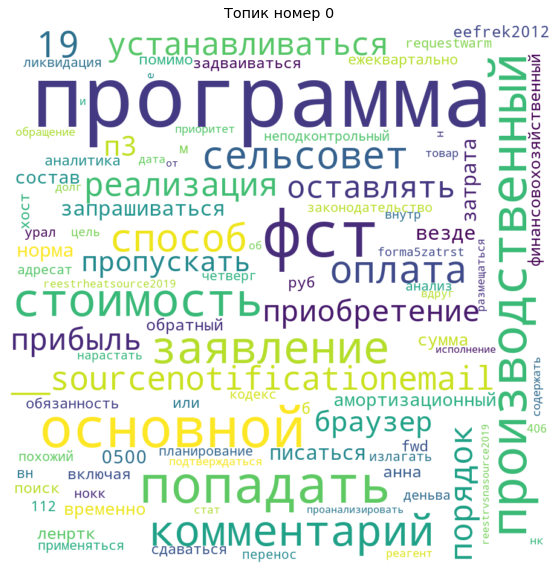

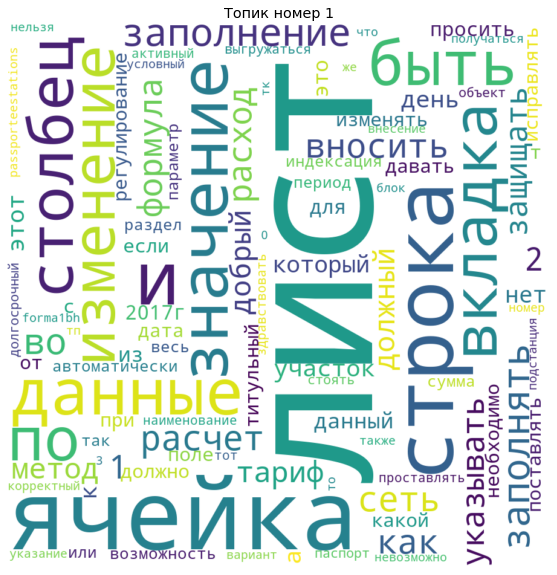

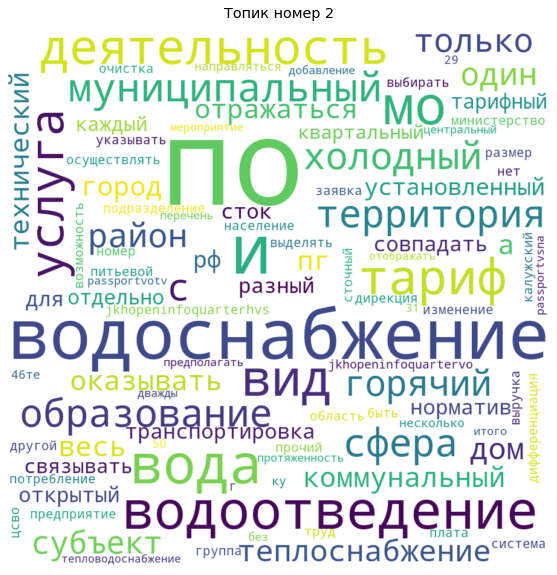

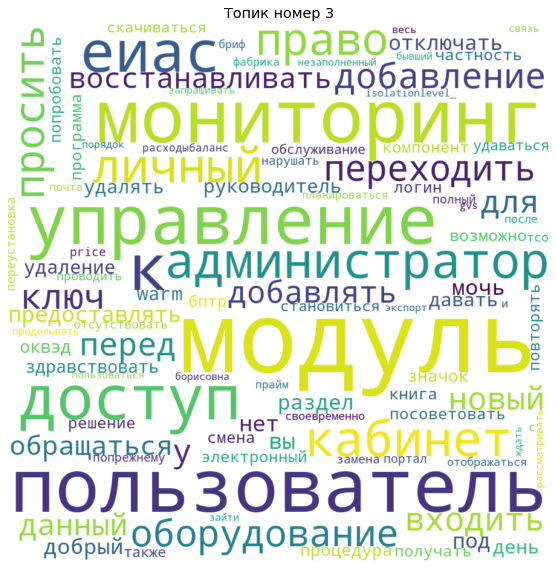

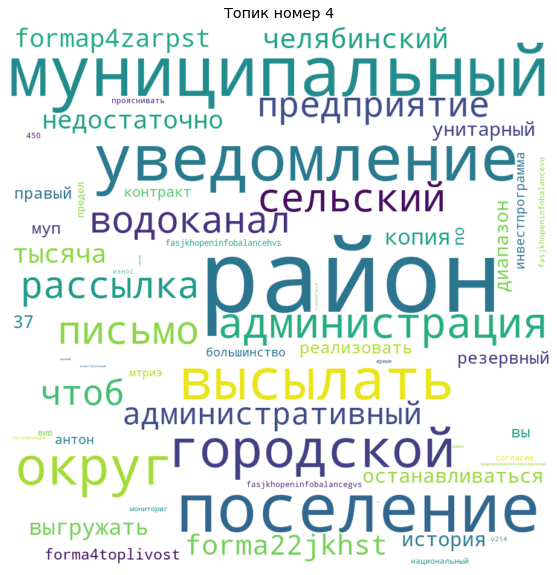

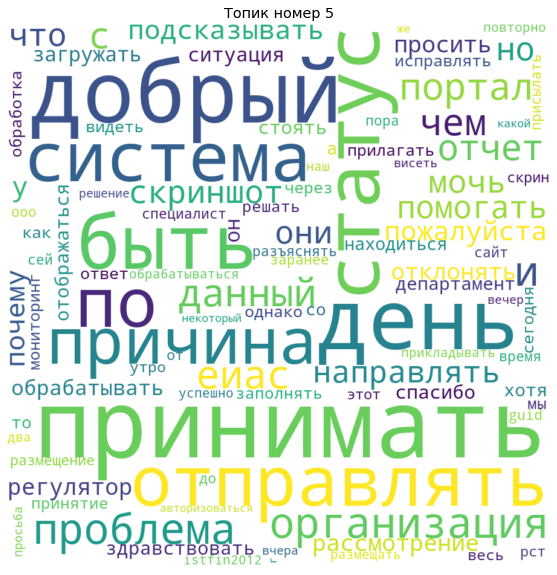

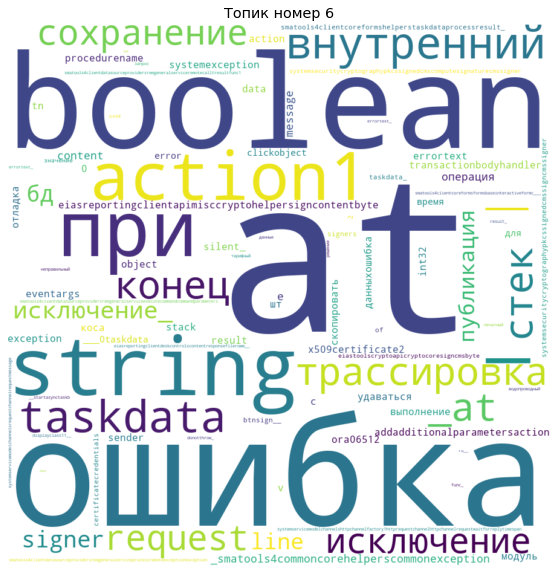

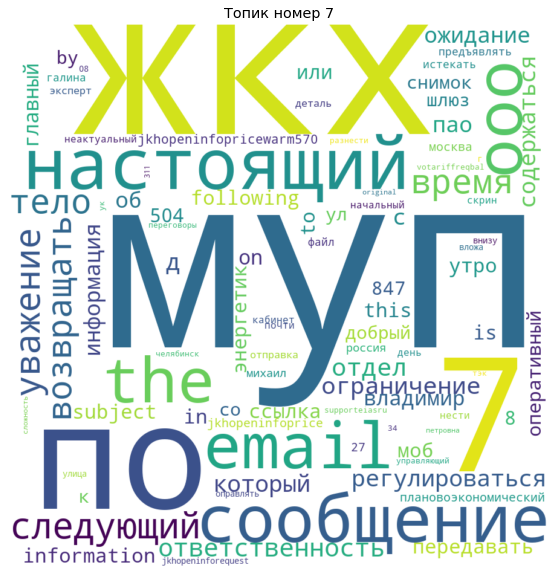

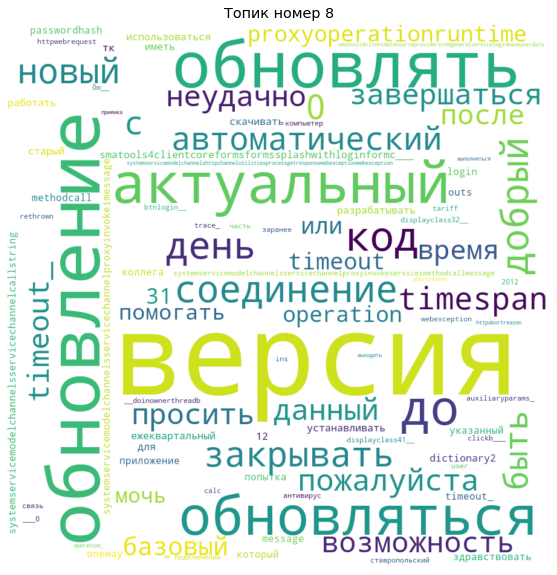

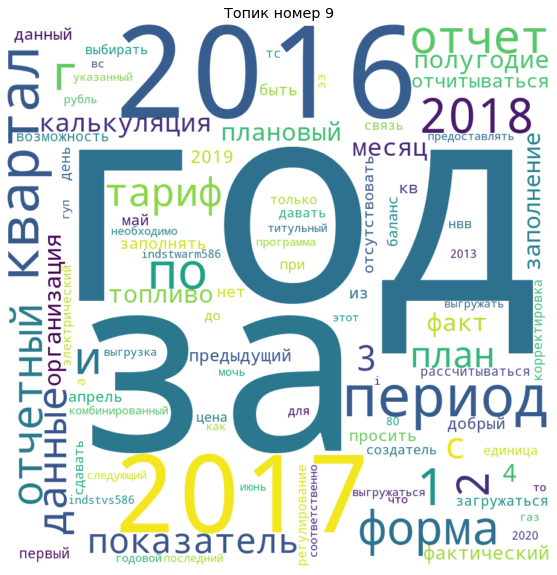

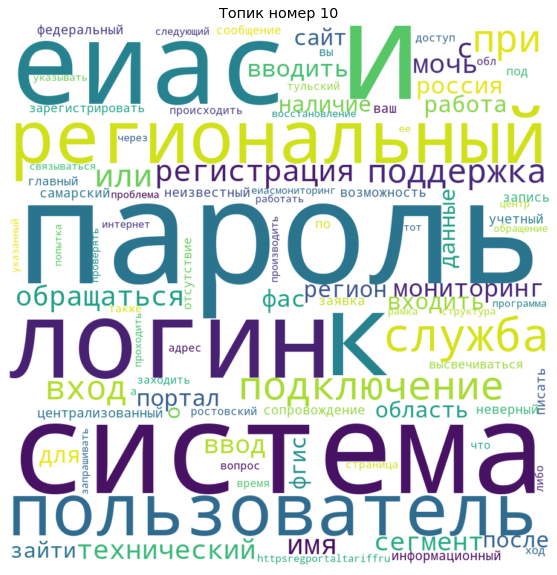

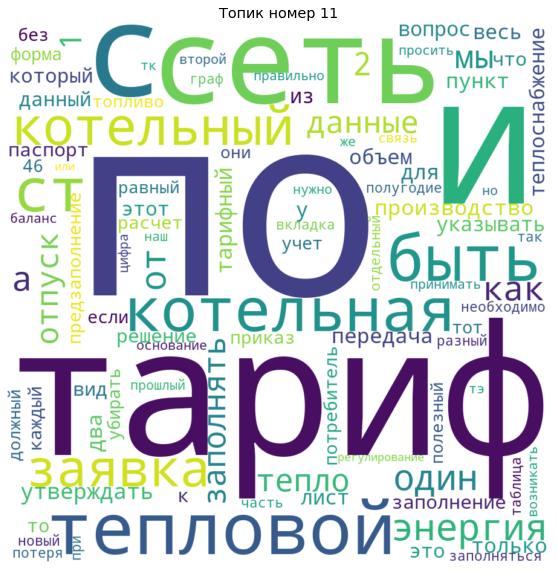

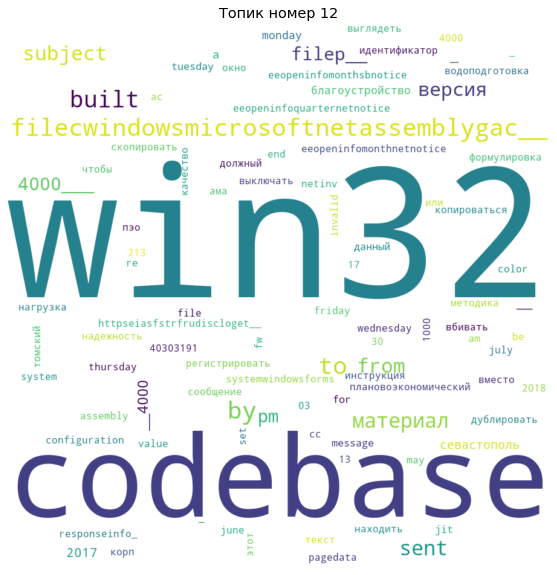

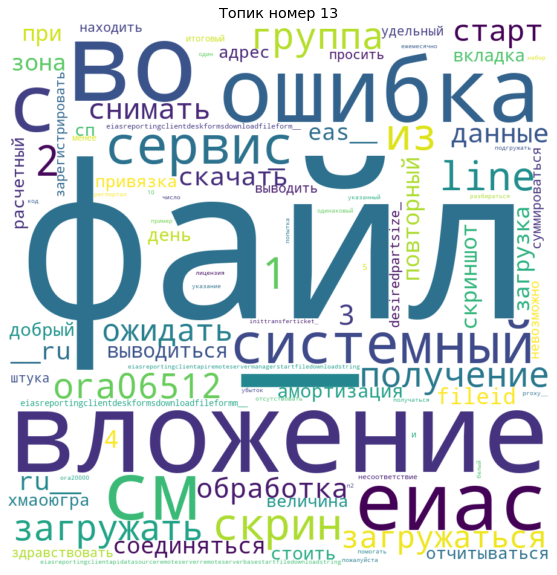

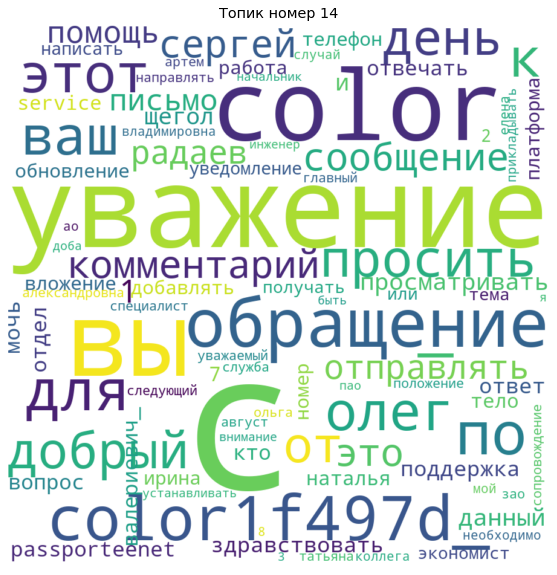

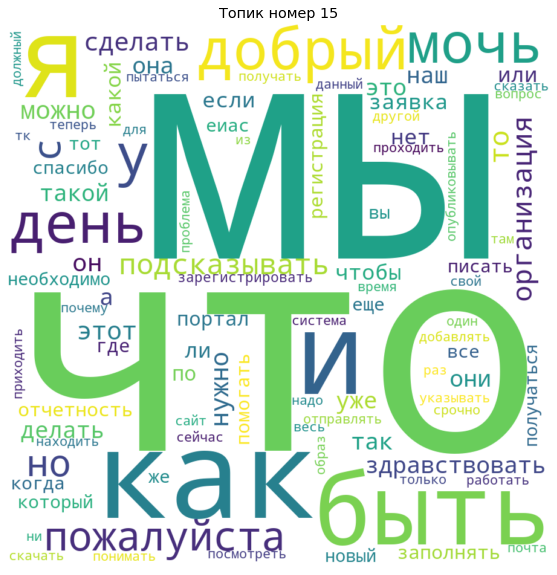

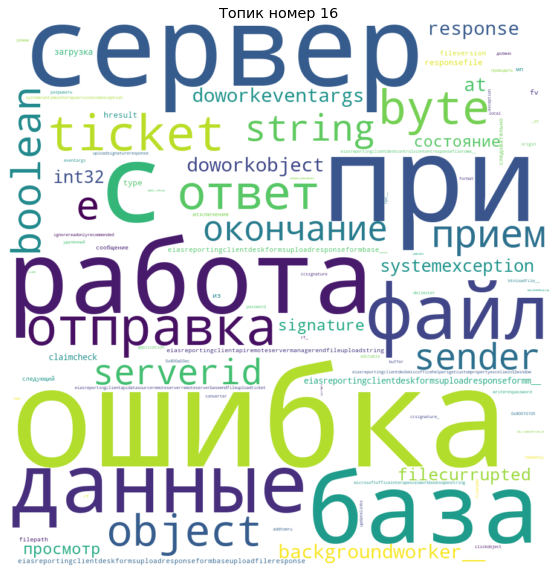

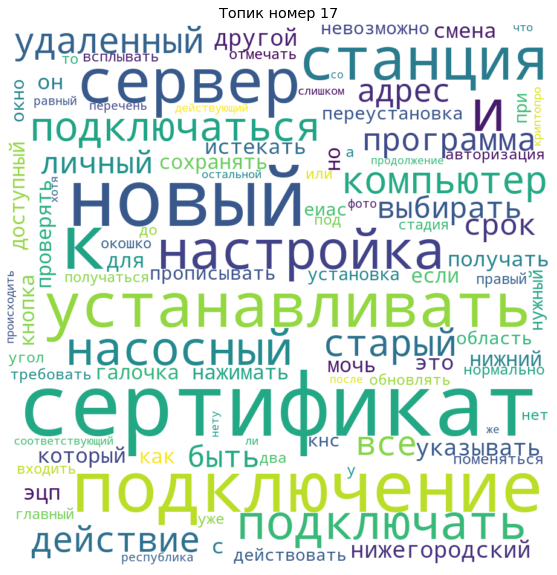

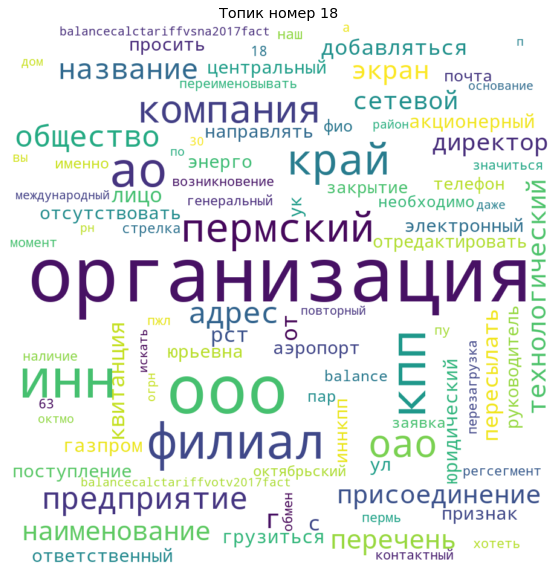

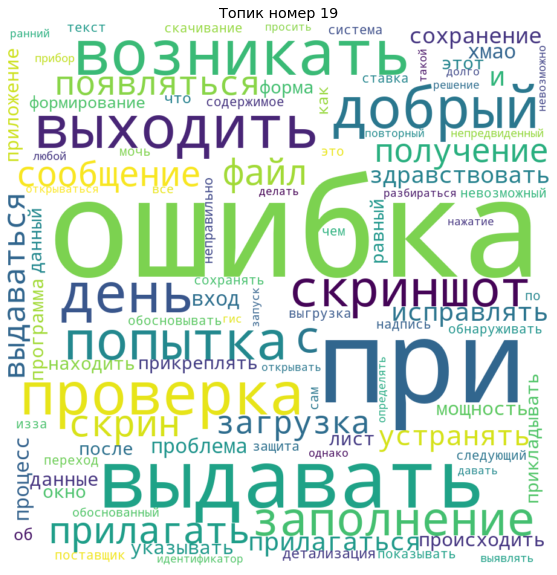

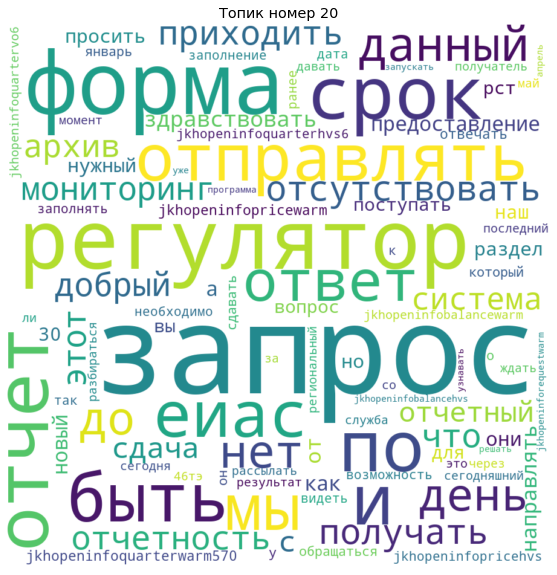

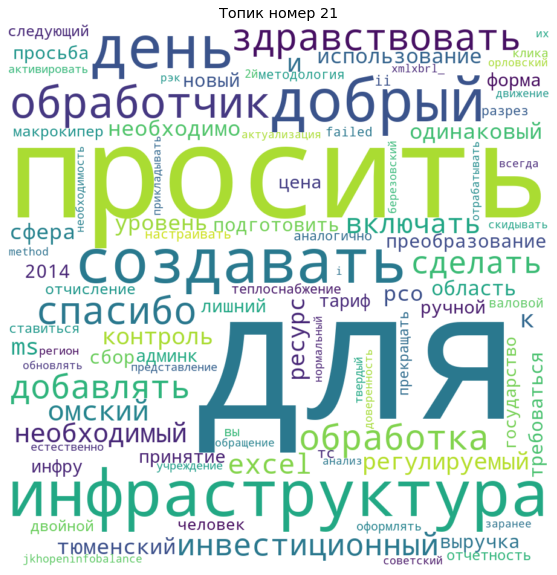

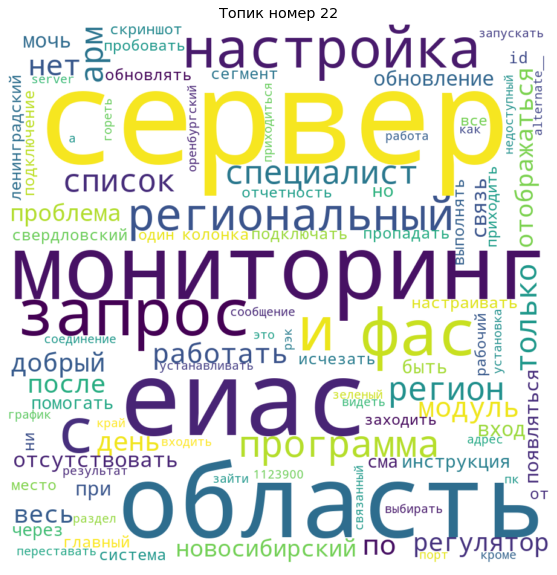

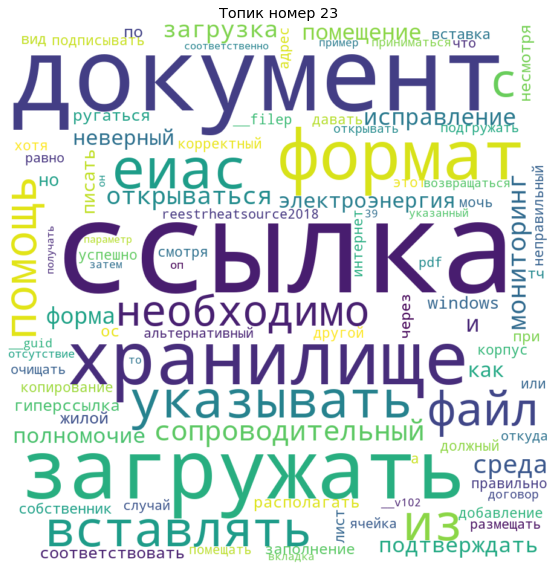

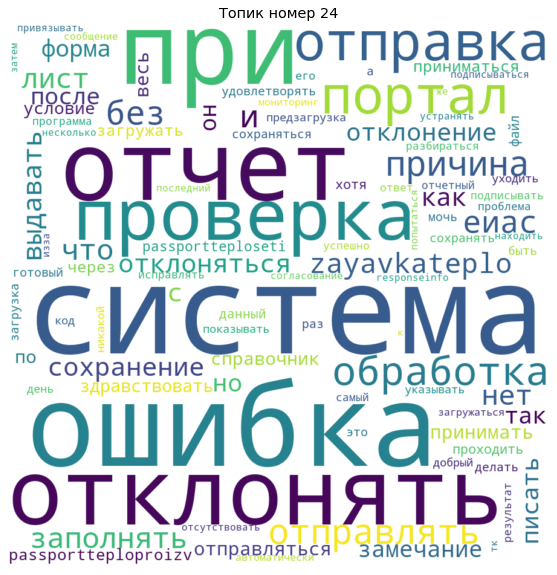

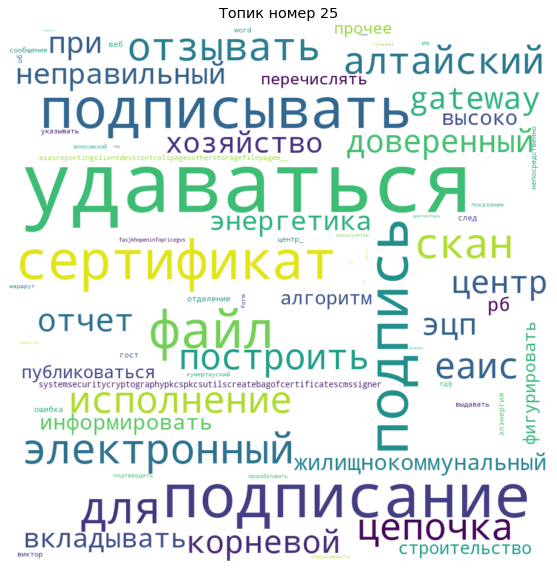

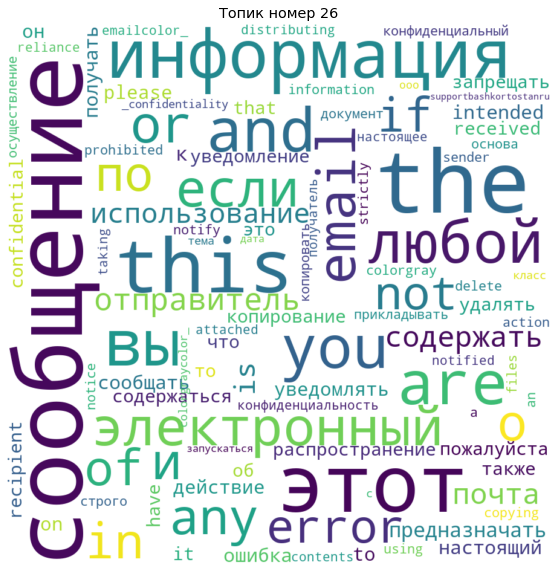

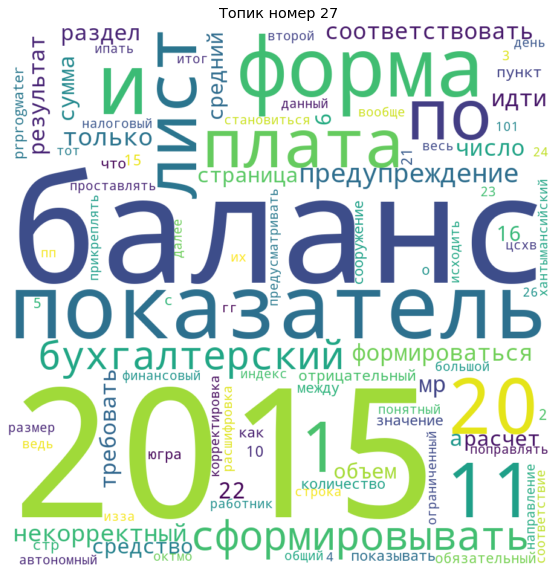

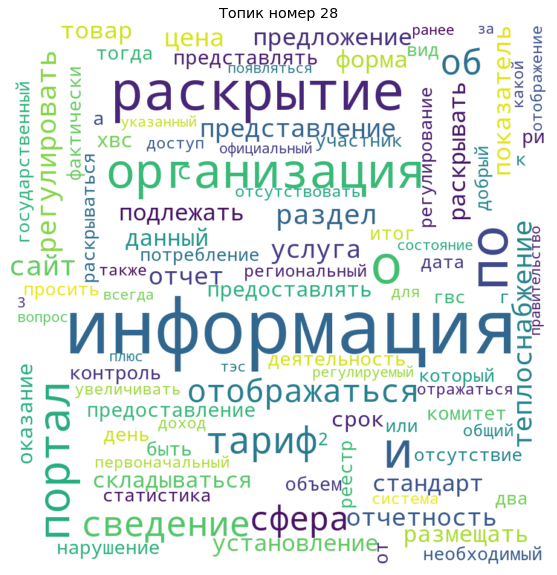

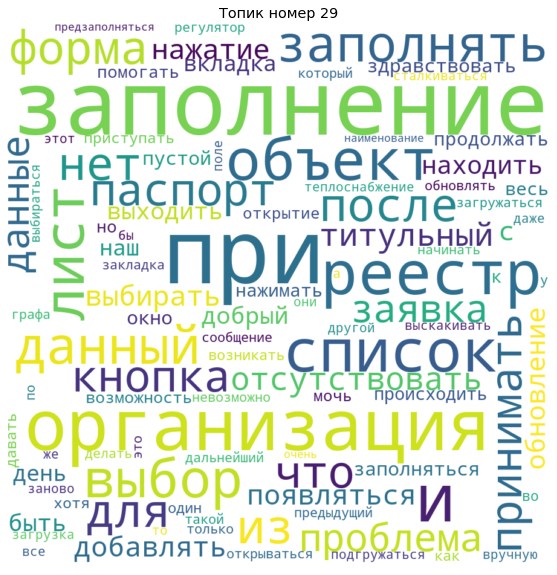

In [21]:
for i in range(30):
    plotWordCloud(topic_number=i)